<a href="https://colab.research.google.com/github/NeuromatchAcademy/course-content/blob/W0postcourse/tutorials/W0D2_PythonWorkshop2/W0D2_Tutorial1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neuromatch Academy: Week 0, Day 2, Tutorial 1
# Python for NMA - LIF Neuron - Part II

__Content creators:__ Marco Brigham and the [CCNSS](https://www.ccnss.org/) team

__Content reviewers:__ Michael Waskom, Karolina Stosio, Spiros Chavlis

---
## Tutorial objectives
We learned basic Python and NumPy concepts in the previous tutorial. These new and efficient coding techniques can be applied repeatedly in tutorials from the NMA course, and elsewhere. Please keep them in mind!

&nbsp; 

In this tutorial, we'll introduce spikes in our LIF neuron and evaluate the refractory period's effect in spiking dynamics!

&nbsp; 

Please remember that strengthening your "Python" leg will help you advance your "Neuro" leg. Alright, let's go for our second walk!

---
# Setup

In [1]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import YouTubeVideo

In [2]:
# @title Figure settings
import ipywidgets as widgets
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/nma.mplstyle")

In [3]:
# @title Helper functions

t_max = 150e-3   # second
dt = 1e-3        # second
tau = 20e-3      # second
el = -60e-3      # milivolt
vr = -70e-3      # milivolt
vth = -50e-3     # milivolt
r = 100e6        # ohm
i_mean = 25e-11  # ampere


def plot_all(t_range, v, raster=None, spikes=None, spikes_mean=None):
  """
  Plots Time evolution for
  (1) multiple realizations of membrane potential
  (2) spikes
  (3) mean spike rate (optional)
  
  Args:
    t_range (numpy array of floats)
        range of time steps for the plots of shape (time steps)

    v (numpy array of floats)
        membrane potential values of shape (neurons, time steps)

    raster (numpy array of floats)
        spike raster of shape (neurons, time steps)

    spikes (dictionary of lists)
        list with spike times indexed by neuron number

    spikes_mean (numpy array of floats)
        Mean spike rate for spikes as dictionary
            
  Returns:
    Nothing.
  """

  v_mean = np.mean(v, axis=0)
  fig_w, fig_h = plt.rcParams['figure.figsize']
  plt.figure(figsize=(fig_w, 1.5 * fig_h))

  ax1 = plt.subplot(3, 1, 1)
  for j in range(n):
    plt.scatter(t_range, v_n[j], color="k", marker=".", alpha=0.01)
  plt.plot(t_range, v_mean, 'C1', alpha=0.8, linewidth=3)
  plt.xticks([])
  plt.ylabel(r'$V_m$ (V)')

  if raster is not None:
    plt.subplot(3, 1, 2)
    spikes_mean = np.mean(raster, axis=0)
    plt.imshow(raster, cmap='Greys', origin='lower', aspect='auto')

  else:
    plt.subplot(3, 1, 2, sharex=ax1)
    for j in range(n):
      times = np.array(spikes[j])
      plt.scatter(times, j * np.ones_like(times), color="C0", marker=".", alpha=0.2)
        
  plt.xticks([])
  plt.ylabel('neuron')

  if spikes_mean is not None:
    plt.subplot(3, 1, 3, sharex=ax1)
    plt.plot(t_range, spikes_mean)
    plt.xlabel('time (s)')
    plt.ylabel('rate (Hz)')

  plt.tight_layout()
  plt.show()

---
# Sample histogram
![histogram statistics](https://github.com/mpbrigham/colaboratory-figures/raw/master/nma/python-for-nma/histogram_statistics.png)

Another important statistic is the sample [histogram](https://en.wikipedia.org/wiki/Histogram). For our LIF neuron it provides an approximate representation of the distribution of membrane potential $V_m(t)$ at time $t=t_k\in[0,t_{max}]$. For $N$ realizations $V\left(t_k\right)$ and $J$ bins is given by:
 
\begin{align*}
\\
N = \sum_{j=1}^{J} m_j\\
\\
\end{align*}

where $m_j$ is a function that counts the number of samples $V\left(t_k\right)$ that fall into bin $j$.

Video available at https://youtube.com/watch?v=71f1J98zj80


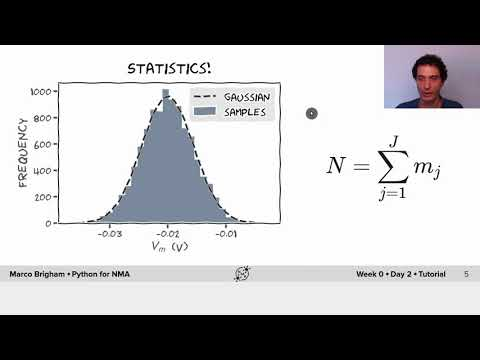

In [4]:
# @title Video: Sample histogram
video = YouTubeVideo(id='71f1J98zj80', width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)
video

## Exercise 1
Plot an histogram of $J=50$ bins of $N=10000$ realizations of $V(t)$ for $t=t_{max}/10$ and $t=t_{max}$.

The function `plt.hist(data, nbins)` plots an histogram of `data` in `nbins` bins. The argument `label` defines a label for `data` and `plt.legend()` adds all labels to the plot.

    plt.hist(data, bins, label='my data')
    plt.legend()
    plt.show()

The parameters `histtype='stepfilled'` and `linewidth=0` may improve histogram appearance (depending on taste). You can read more about [different histtype settings](https://matplotlib.org/gallery/statistics/histogram_histtypes.html).

The function `plt.hist` returns the `pdf`, `bins`, and `patches` with the histogram bins, the edges of the bins, and the individual patches used to create the histogram.

    pdf, bins, patches = plt.hist(data, bins)

We'll make a small correction in the definition of `t_range` to ensure increments of `dt` by using `np.arange` instead of `np.linspace`. (Why is it needed?)

    numpy.arange(start, stop, step)

**Suggestions**
* Plot the 1st histogram after running up to $t=t_{max}/10$
* Plot the 2nd histogram at $t=t_{max}$
* Add labels to identify the time of each histogram
* Plot each histogram with parameters `histtype='stepfilled'` and `linewidth=0`

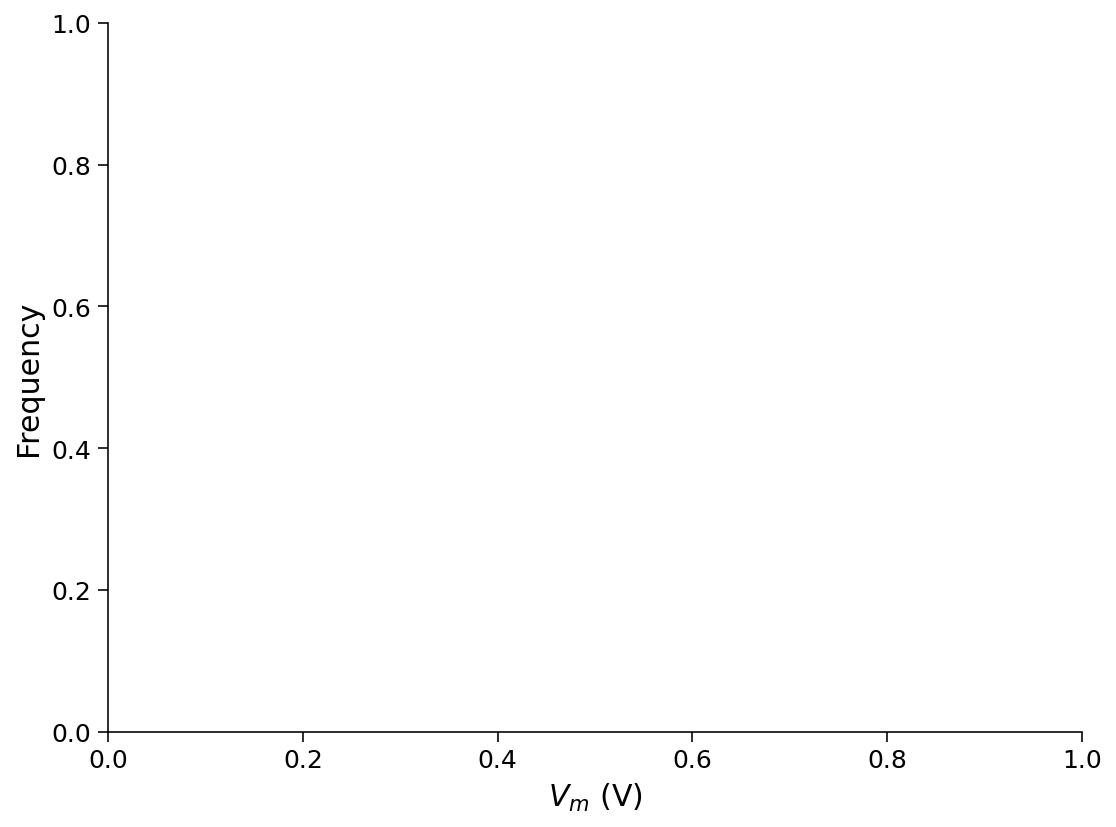

In [5]:
# set random number generator
np.random.seed(2020)

# initialize t_range, step_end, n, v_n, syn and nbins
t_range = np.arange(0, t_max, dt)
step_end = len(t_range)

n = 10000
v_n = el * np.ones([n, step_end])
syn = i_mean * (1 + 0.1 * (t_max / dt)**(0.5)*(2 * np.random.random([n, step_end]) - 1))
nbins = 32

# loop time steps
for step, t in enumerate(t_range):
  if step==0:
    continue

  v_n[:, step] = v_n[:, step - 1] + (dt / tau) * (el - v_n[:, step - 1] + r*syn[:, step])

# initialize the figure
plt.figure()
plt.ylabel('Frequency')
plt.xlabel('$V_m$ (V)')

# Complete these lines and uncomment
# plt.hist(...)
# plt.hist(...)
# plt.legend()
plt.show()

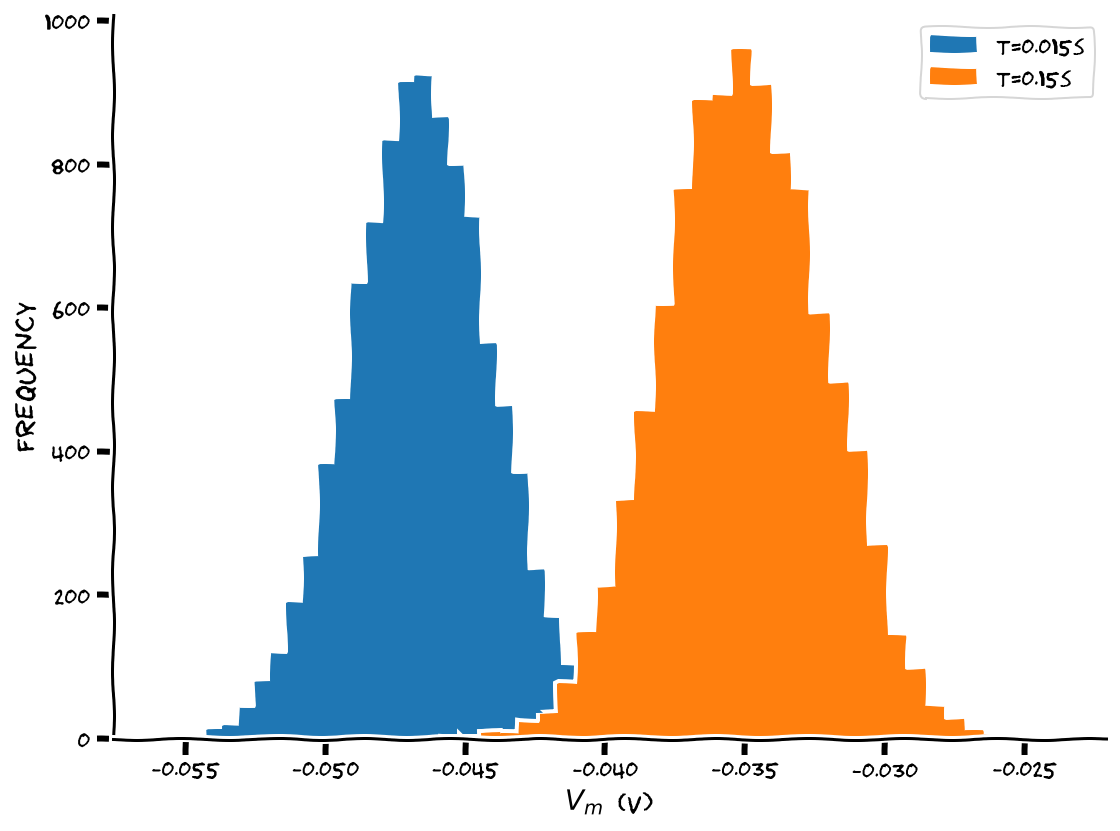

In [6]:
# to_remove solution
# set random number generator
np.random.seed(2020)

# initialize step_end, t_range, n, v_n, syn and nbins
t_range = np.arange(0, t_max, dt)
step_end = len(t_range)
n = 10000
v_n = el * np.ones([n,step_end])
syn = i_mean * (1 + 0.1 * (t_max / dt)**(0.5) * (2 * np.random.random([n, step_end]) - 1))
nbins = 32

# loop for step_end - 1 steps
for step, t in enumerate(t_range):
  if step==0:
    continue

  v_n[:, step] =  v_n[:, step - 1] + (dt / tau) * (el - v_n[:, step - 1] + r*syn[:, step])

with plt.xkcd():

  # initialize the figure
  plt.figure()
  plt.ylabel('Frequency')
  plt.xlabel('$V_m$ (V)')

  plt.hist(v_n[:,int(step_end / 10)], nbins,
           histtype='stepfilled', linewidth=0,
           label = 't='+ str(t_max / 10) + 's')
  plt.hist(v_n[:, -1], nbins,
           histtype='stepfilled', linewidth=0,
           label = 't='+ str(t_max) + 's')
  plt.legend()
  plt.show()

---
# Introduce spikes
A spike takes place whenever $V(t)$ crosses $V_{th}$. In that case, a spike is recorded and $V(t)$ resets to $V_{reset}$ value. This is summarized in the *reset condition*:
$$V(t) = V_{reset}\quad \text{ if } V(t)\geq V_{th}$$

For more information about spikes or action potentials see [here](https://en.wikipedia.org/wiki/Action_potential) and [here](https://www.khanacademy.org/test-prep/mcat/organ-systems/neuron-membrane-potentials/a/neuron-action-potentials-the-creation-of-a-brain-signal).


![spikes cartoon](https://github.com/mpbrigham/colaboratory-figures/raw/master/nma/python-for-nma/spikes_carton.png)

Video available at https://youtube.com/watch?v=nvpHtzuZggg


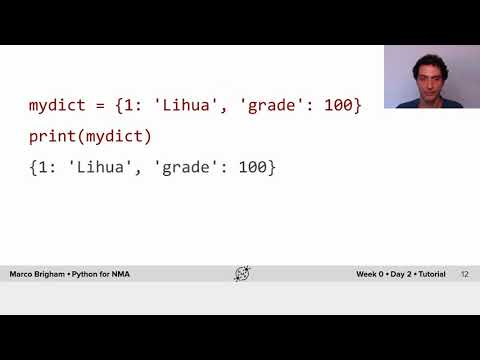

In [7]:
# @title Video: Spikes
from IPython.display import YouTubeVideo
video = YouTubeVideo(id='nvpHtzuZggg', width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)
video

## Exercise 2
Insert the reset condition, and collect the spike times of each realization in a dictionary variable `spikes`, with $N=500$.

We've used `plt.plot` for plotting lines and also for plotting dots at `(x,y)` coordinates, which is a [scatter plot](https://en.wikipedia.org/wiki/Scatter_plot). From here on, we'll use use `plt.plot` for plotting lines and for scatter plots: `plt.scatter`.
```
plt.scatter(x, y, color="k", marker=".")
```

A *raster plot* represents spikes from multiple neurons by plotting dots at spike times from neuron `j` at plot height `j`, i.e. 
```
plt.scatter(spike_times, j*np.ones_like(spike_times))
```

![spikes plot](https://github.com/mpbrigham/colaboratory-figures/raw/master/nma/python-for-nma/spikes_plot.png)

In this exercise, we use `plt.subplot` for multiple plots in the same figure. These plots can share the same `x` or `y` axis by specifying the parameter `sharex` or `sharey`. Add `plt.tight_layout()` at the end to automatically adjust subplot parameters to fit the figure area better. Please see the example below for a row of two plots sharing axis `y`.
```
# initialize the figure
plt.figure()

# collect axis of 1st figure in ax1
ax1 = plt.subplot(1, 2, 1)
plt.plot(t_range, my_data_left)
plt.ylabel('ylabel')

# share axis x with 1st figure
plt.subplot(1, 2, 2, sharey=ax1)
plt.plot(t_range, my_data_right)

# automatically adjust subplot parameters to figure
plt.tight_layout()
```

**Suggestions**
* At each time step loop all neurons to:
  * Reset $V_n(t)$ to $V_{reset}$ if $V_n(t)\geq V_{th}$
  * Collect spike times in dictionary `spikes` indexed by neuron number
  * Add spike count to numpy array `spikes_n`
  * In `plt.subplot(3, 1, 2)` loop each neuron to collect and plot spike times
  * Plot realizations and sample mean in `plt.subplot(3, 1, 1)`, and mean spiking rate in `plt.subplot(3, 1, 3)`

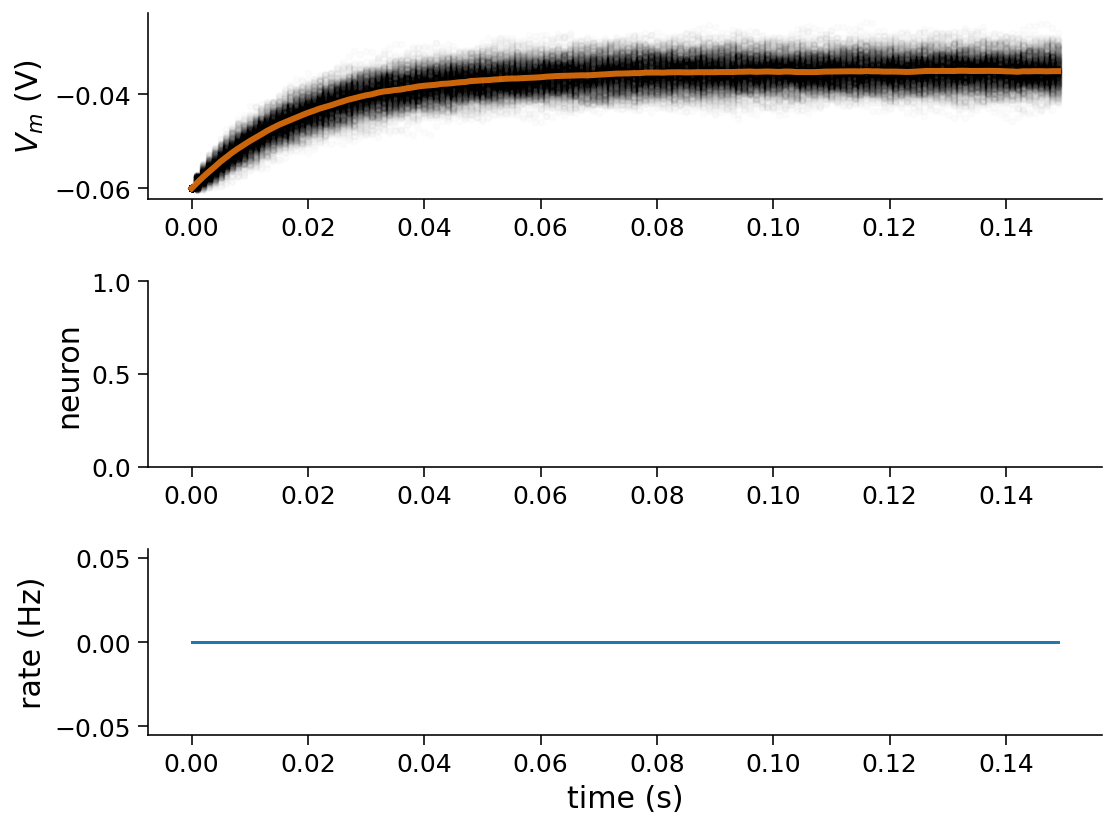

In [8]:
# set random number generator
np.random.seed(2020)

# initialize step_end, t_range, n, v_n and syn
t_range = np.arange(0, t_max, dt)
step_end = len(t_range)
n = 500
v_n = el * np.ones([n,step_end])
syn = i_mean * (1 + 0.1 * (t_max / dt)**(0.5) * (2 * np.random.random([n, step_end]) - 1))

# initialize spikes and spikes_n
spikes = {j: [] for j in range(n)}
spikes_n = np.zeros([step_end])

# loop time steps
for step, t in enumerate(t_range):
  if step==0:
    continue

  v_n[:, step] = v_n[:, step - 1] + (dt / tau) * (el - v_n[:, step - 1] + r*syn[:, step])

  # collect spike times and reset to resting potential
  # Complete these lines and uncomment
  # for j in range(0, n):
      # if ...:
        # v_n[j, step] = ...
        # spikes[j] += ...
        # spikes_n[step] += ...

# collect mean Vm and mean spiking rate
v_mean = np.mean(v_n, axis=0)
spikes_mean =  spikes_n / n

# initialize the figure
plt.figure()

# collect axis of 1st figure in ax1
ax1 = plt.subplot(3, 1, 1)
for j in range(n):
  plt.scatter(t_range, v_n[j], color="k", marker=".", alpha=0.01)
plt.plot(t_range, v_mean, 'C1', alpha=0.8, linewidth=3)
plt.ylabel('$V_m$ (V)')

# share xaxis with 1st figure
plt.subplot(3, 1, 2, sharex=ax1)
# for each neuron j: collect spike times and plot them at height j
# Complete these lines and uncomment
# for j in range(n):
  # times = ...
  # plt.scatter(...)

plt.ylabel('neuron')

# share xaxis with 1st figure
plt.subplot(3, 1, 3, sharex=ax1)
plt.plot(t_range, spikes_mean)
plt.xlabel('time (s)')
plt.ylabel('rate (Hz)')

plt.tight_layout()

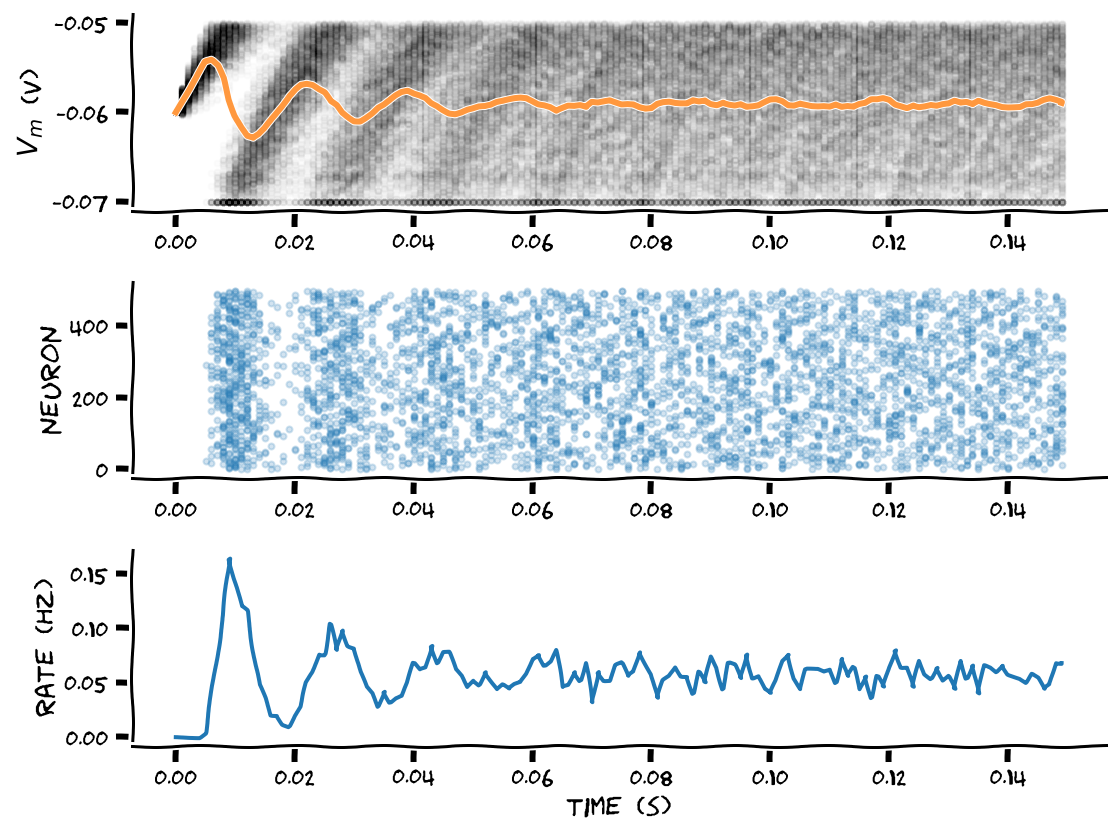

In [9]:
# to_remove solution
# set random number generator
np.random.seed(2020)

# initialize step_end, t_range, n, v_n and syn
t_range = np.arange(0, t_max, dt)
step_end = len(t_range)
n = 500
v_n = el * np.ones([n, step_end])
syn = i_mean * (1 + 0.1 * (t_max / dt)**(0.5) * (2 * np.random.random([n, step_end]) - 1))

# initialize spikes and spikes_n
spikes = {j: [] for j in range(n)}
spikes_n = np.zeros([step_end])

# loop time steps
for step, t in enumerate(t_range):
  if step==0:
    continue

  v_n[:, step] = v_n[:, step - 1] + (dt / tau) * (el - v_n[:, step - 1] + r*syn[:, step])

  # collect spike times and reset to resting potential
  for j in range(0, n):
    if v_n[j, step] >= vth:
      v_n[j, step] = vr
      spikes[j] += [t]
      spikes_n[step] += 1

# collect mean Vm and mean spiking rate
v_mean = np.mean(v_n, axis=0)
spikes_mean =  spikes_n / n

# initialize the figure
with plt.xkcd():
  plt.figure()

  # collect axis of 1st figure in ax1
  ax1 = plt.subplot(3, 1, 1)
  for j in range(n):
    plt.scatter(t_range, v_n[j], color="k", marker=".", alpha=0.01)
  plt.plot(t_range, v_mean, 'C1', alpha=0.8, linewidth=3)
  plt.ylabel('$V_m$ (V)')

  # share xaxis with 1st figure
  plt.subplot(3, 1, 2, sharex=ax1)
  # for each neuron j: collect spike times and plot them at height j
  for j in range(n):
    times = np.array(spikes[j])
    plt.scatter(times, j * np.ones_like(times), color="C0", marker=".", alpha=0.2)
  plt.ylabel('neuron')

  # share xaxis with 1st figure
  plt.subplot(3, 1, 3, sharex=ax1)
  plt.plot(t_range, spikes_mean)
  plt.xlabel('time (s)')
  plt.ylabel('rate (Hz)')

  plt.tight_layout()
  plt.show()

---
# Boolean indexes
Numpy arrays can be indexed by boolean arrays to select a subset of elements (also works with lists of booleans).

The boolean array itself can be initiated by a condition, as shown in the example below.
```
a = np.array([1, 2, 3])
b = a>=2
print(b)
--> [False  True  True]

print(a[b])
--> [2 3]

print(a[a>=2])
--> [2 3]
```

Video available at https://youtube.com/watch?v=dFPgO5wnyLc


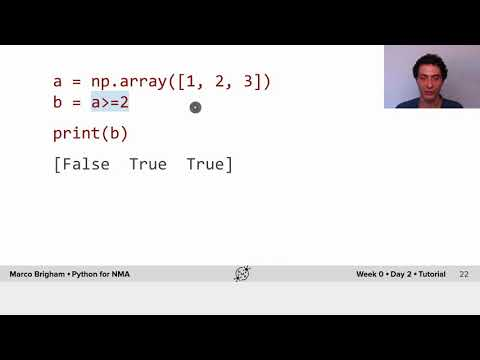

In [10]:
#@title Video: Boolean indexes
from IPython.display import YouTubeVideo
video = YouTubeVideo(id='dFPgO5wnyLc', width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)
video

## Exercise 3
We can avoid looping all neurons in each time step by identifying with boolean arrays the indexes of neurons that spiked in the previous step.

In the example below, `v_rest` is a boolean numpy array with `True` in each index of `v_n` with value `vr` at time index `step`:

    v_rest = (v_n[:,step] == vr)
    print(v_n[v_rest,step])
    
    --> [vr, ..., vr]

The function `np.where` returns indexes of boolean arrays with `True` values.

You may use the helper function `plot_all` that implements the figure from the previous exercise.

**Suggestions**
* At each time step:
  * Initialize boolean numpy array `spiked` with $V_n(t)\geq V_{th}$
  * Set to `vr` indexes of `v_n` using `spiked`
  * Obtain indexes of spiking neurons using `np.where(spiked)[0]`
  * Collect spike times in dictionary `spikes` and spike count in numpy array `spikes_n`

**Helper function(s)**

In [11]:
help(plot_all)

Help on function plot_all in module __main__:

plot_all(t_range, v, raster=None, spikes=None, spikes_mean=None)
    Plots Time evolution for
    (1) multiple realizations of membrane potential
    (2) spikes
    (3) mean spike rate (optional)
    
    Args:
      t_range (numpy array of floats)
          range of time steps for the plots of shape (time steps)
    
      v (numpy array of floats)
          membrane potential values of shape (neurons, time steps)
    
      raster (numpy array of floats)
          spike raster of shape (neurons, time steps)
    
      spikes (dictionary of lists)
          list with spike times indexed by neuron number
    
      spikes_mean (numpy array of floats)
          Mean spike rate for spikes as dictionary
              
    Returns:
      Nothing.



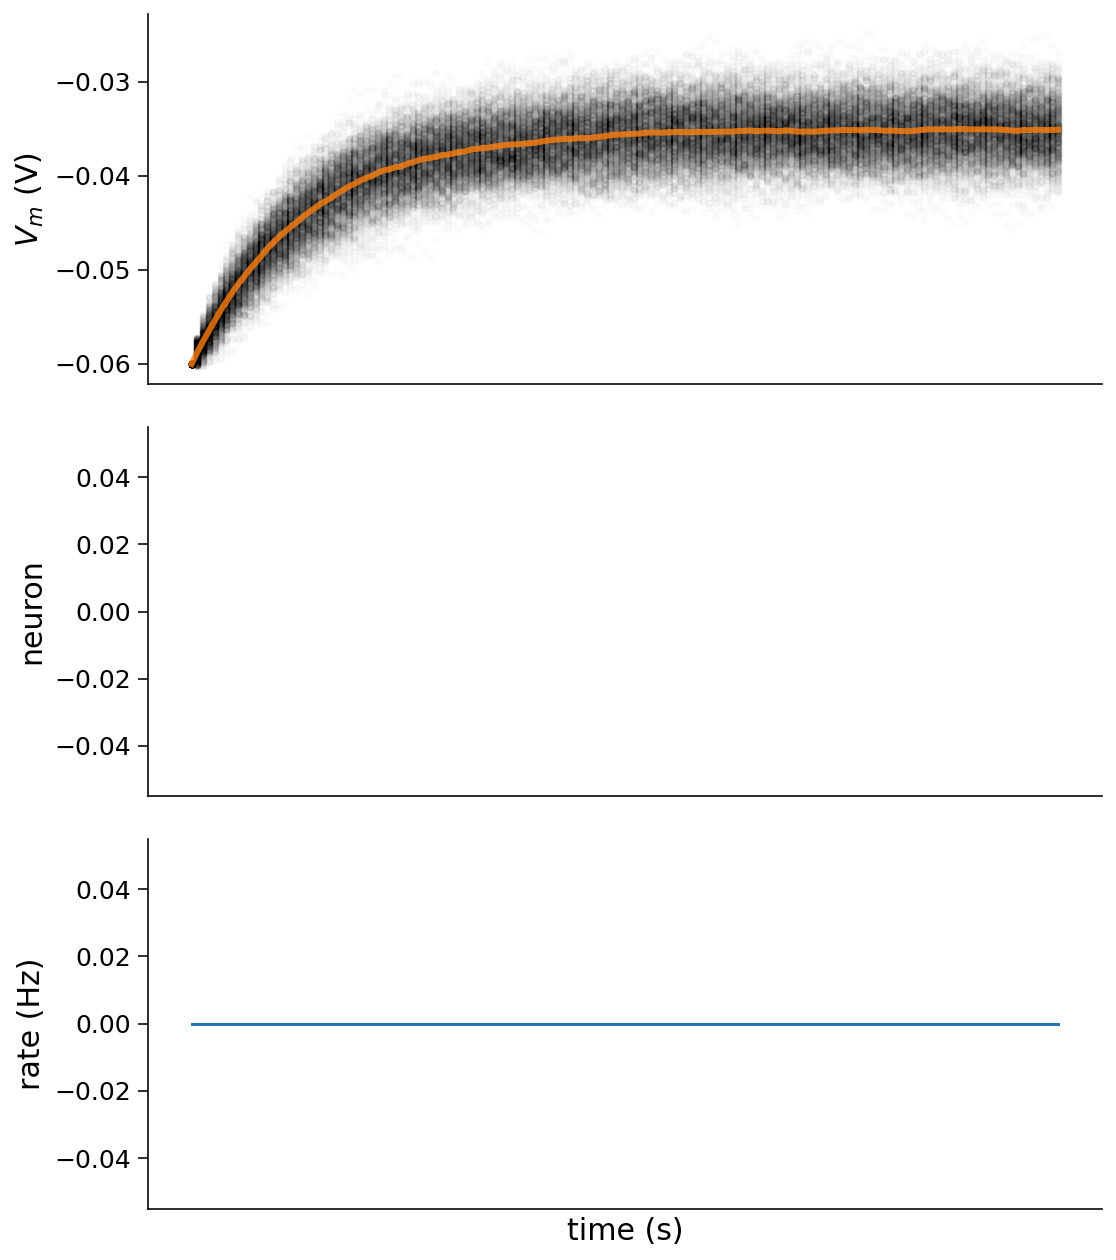

In [12]:
# set random number generator
np.random.seed(2020)

# initialize step_end, t_range, n, v_n and syn
t_range = np.arange(0, t_max, dt)
step_end = len(t_range)
n = 500
v_n = el * np.ones([n,step_end])
syn = i_mean * (1 + 0.1*(t_max/dt)**(0.5)*(2*np.random.random([n,step_end])-1))

# initialize spikes and spikes_n
spikes = {j: [] for j in range(n)}
spikes_n = np.zeros([step_end])

# loop time steps
for step, t in enumerate(t_range):
  if step==0:
    continue

  v_n[:,step] = v_n[:,step-1] + dt/tau * (el - v_n[:,step-1] + r*syn[:,step])

  # collect neurons that spiked and reset to resting potential
  spiked = ...
  # Complete these lines and uncomment
  # v_n[spiked,step] = ...

  # collect spike times
  # for j in np.where(spiked)[0]:
    # spikes[j] += ...
    # spikes_n[step] += ...

# collect mean spiking rate
spikes_mean = spikes_n / n

# plot multiple realizations of Vm, spikes and mean spike rate
plot_all(t_range, v_n, spikes=spikes, spikes_mean=spikes_mean)

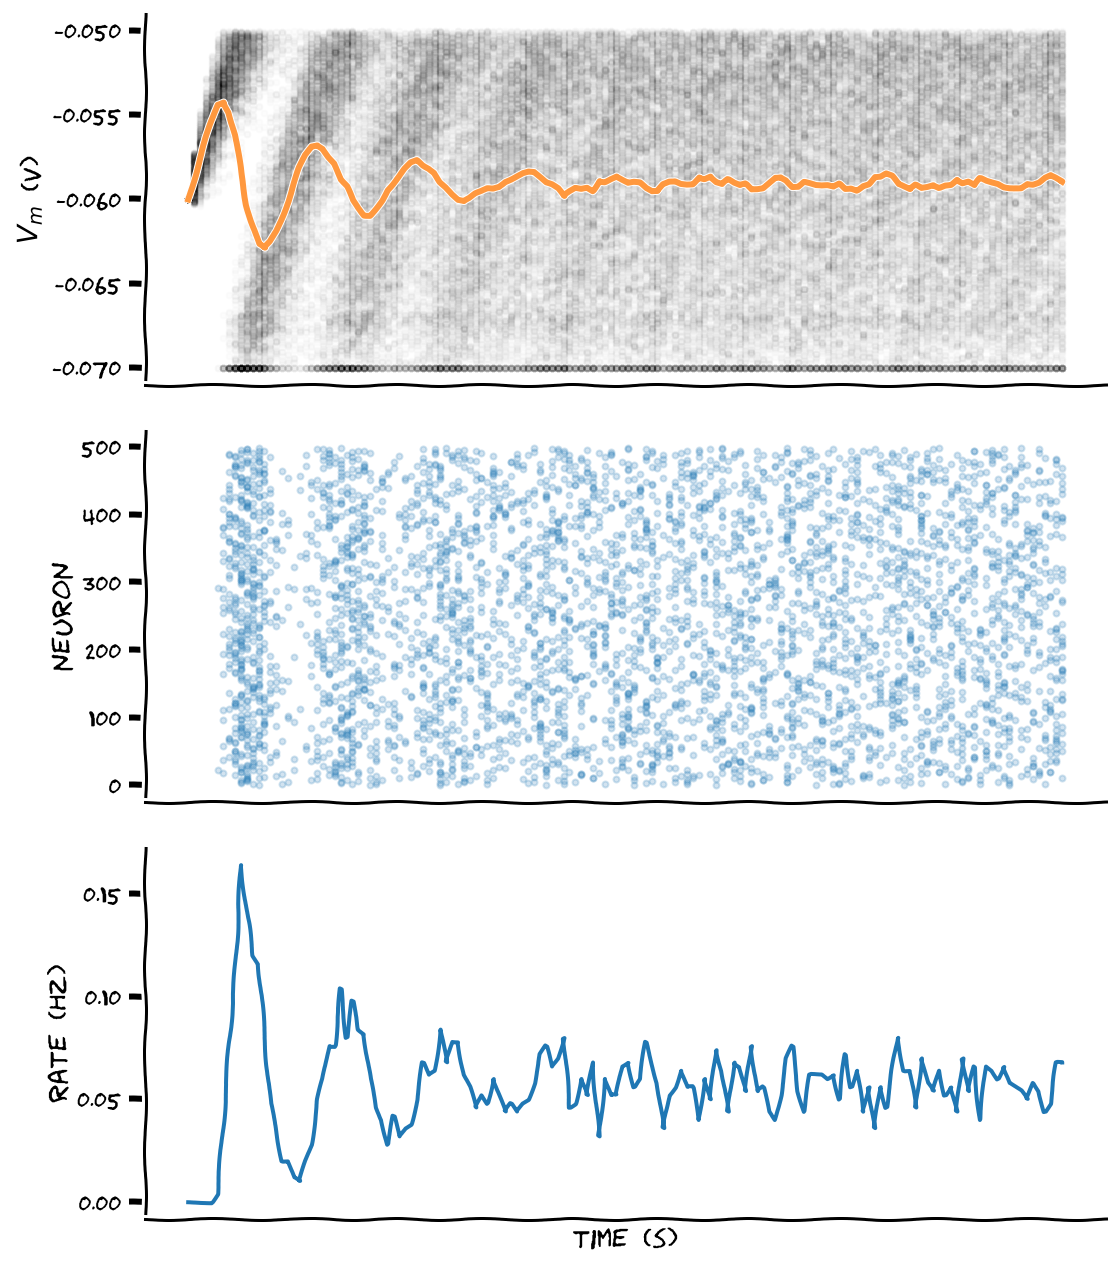

In [13]:
# to_remove solution
# set random number generator
np.random.seed(2020)

# initialize step_end, t_range, n, v_n and syn
t_range = np.arange(0, t_max, dt)
step_end = len(t_range)
n = 500
v_n = el * np.ones([n,step_end])
syn = i_mean * (1 + 0.1*(t_max/dt)**(0.5)*(2*np.random.random([n,step_end])-1))

# initialize spikes and spikes_n
spikes = {j: [] for j in range(n)}
spikes_n = np.zeros([step_end])

# loop time steps
for step, t in enumerate(t_range):
  if step==0:
    continue

  v_n[:,step] = v_n[:,step-1] + dt/tau * (el - v_n[:,step-1] + r*syn[:,step])

  # collect neurons that spiked and reset to resting potential
  spiked = (v_n[:,step] >= vth)
  v_n[spiked,step] = vr

  # collect spike times
  for j in np.where(spiked)[0]:
    spikes[j] += [t]
    spikes_n[step] += 1

# collect mean spiking rate
spikes_mean = spikes_n / n

# plot multiple realizations of Vm, spikes and mean spike rate
with plt.xkcd():
  plot_all(t_range, v_n, spikes=spikes, spikes_mean=spikes_mean)

## Exercise 4
A *binary raster plot* represents spike times as `1`s in a binary grid initialized with `0`s. We start with a numpy array `raster` of zeros with shape `(neurons, time steps)`, and represent a spike from neuron `5` at time step `20` as `raster(5,20)=1`, for example.

The *binary raster plot* is much more efficient than the previous method by plotting the numpy array `raster` as an image:
```
plt.imshow(raster, cmap='Greys', origin='lower', aspect='auto')
```

**Suggestions**
* At each time step:
  * Initialize boolean numpy array `spiked` with $V_n(t)\geq V_{th}$
  * Set to `vr` indexes of `v_n` using `spiked`
  * Set to `1` indexes of numpy array `raster` using `spiked`

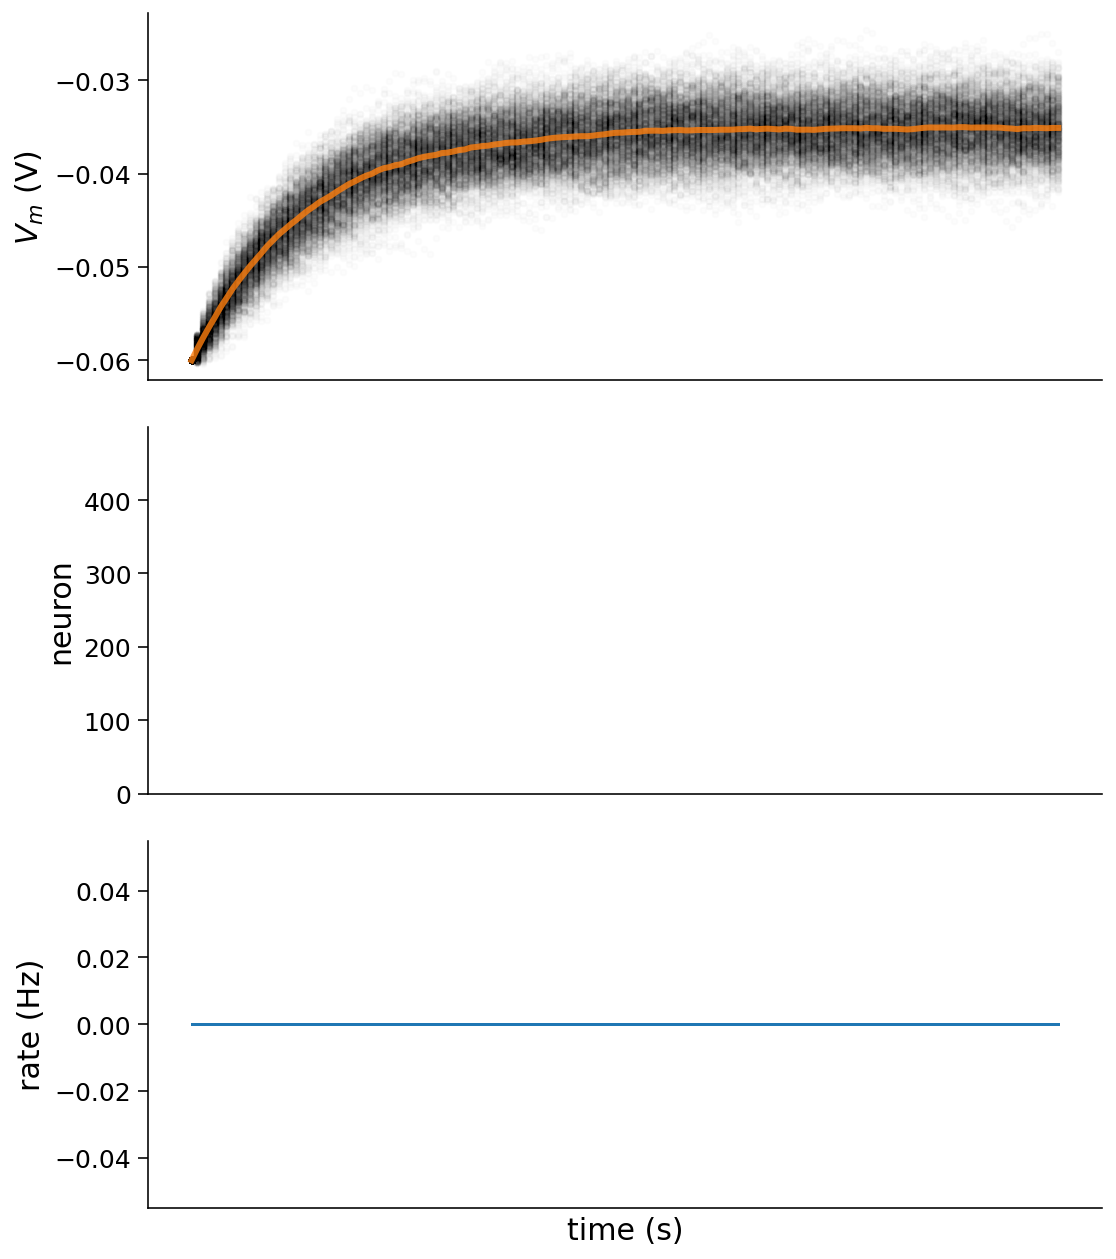

In [14]:
# set random number generator
np.random.seed(2020)

# initialize step_end, t_range, n, v_n and syn
t_range = np.arange(0, t_max, dt)
step_end = len(t_range)
n = 500
v_n = el * np.ones([n,step_end])
syn = i_mean * (1 + 0.1*(t_max/dt)**(0.5)*(2*np.random.random([n,step_end])-1))

# initialize binary numpy array for raster plot
raster = np.zeros([n,step_end])

# loop time steps
for step, t in enumerate(t_range):
  if step==0:
    continue

  v_n[:,step] = v_n[:,step-1] + dt/tau * (el - v_n[:,step-1] + r*syn[:,step])

  # boolean array spiked indexes neurons with v>=vth
  spiked = ...
  # Complete these lines and uncomment
  # v_n[spiked,step] = ...
  # raster[spiked,step] = ...

# plot multiple realizations of Vm, spikes and mean spike rate
plot_all(t_range, v_n, raster)

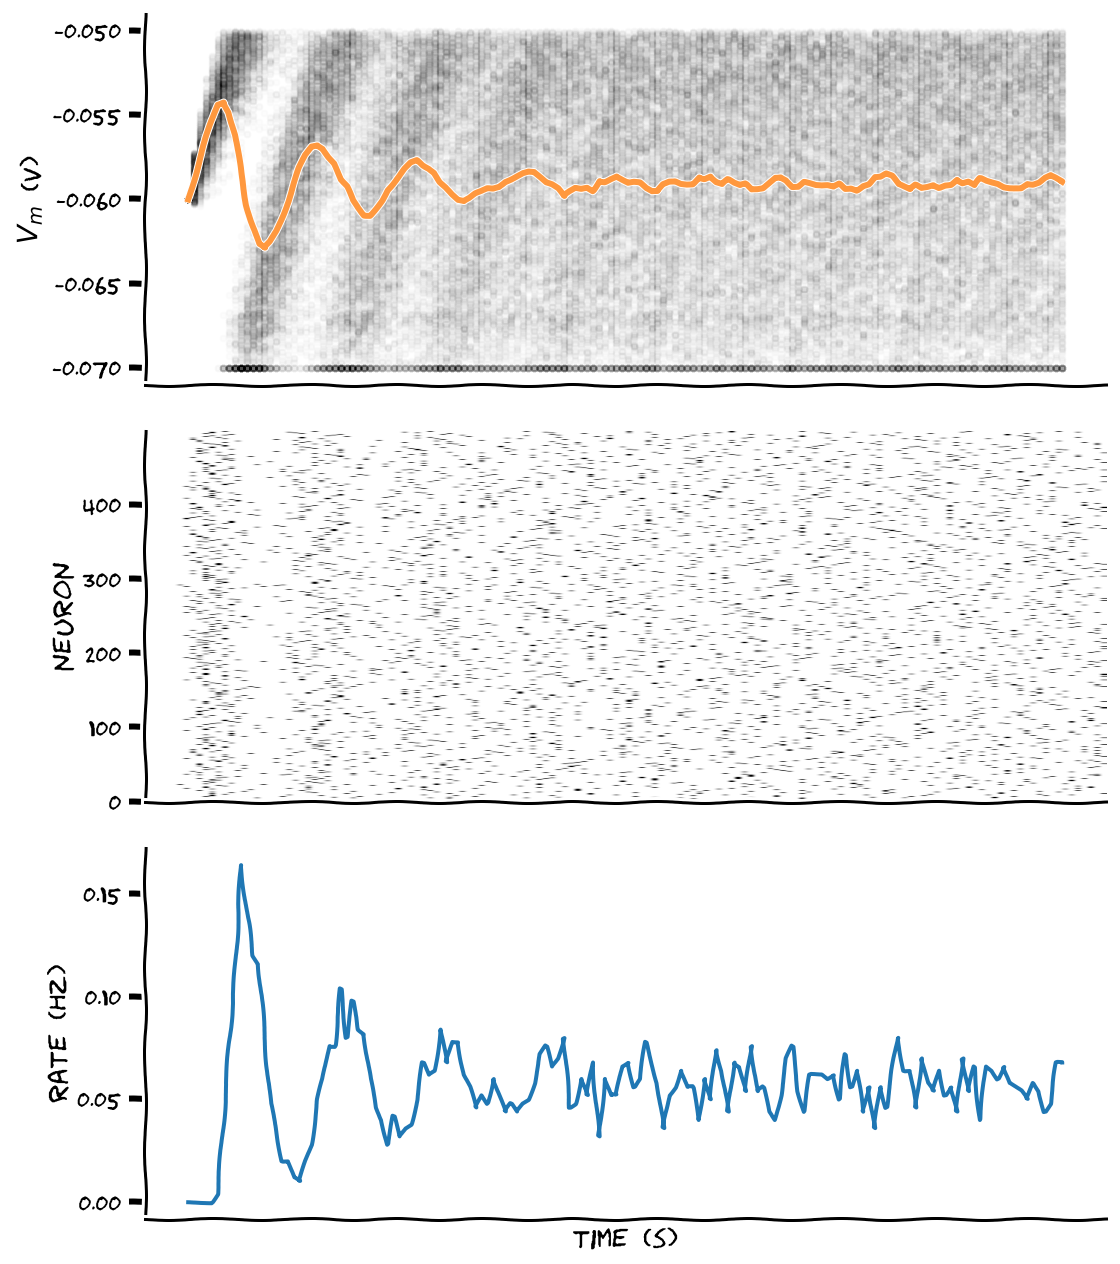

In [15]:
# to_remove solution
# set random number generator
np.random.seed(2020)

# initialize step_end, t_range, n, v_n and syn
t_range = np.arange(0, t_max, dt)
step_end = len(t_range)
n = 500
v_n = el * np.ones([n,step_end])
syn = i_mean * (1 + 0.1*(t_max/dt)**(0.5)*(2*np.random.random([n,step_end])-1))

# initialize binary numpy array for raster plot
raster = np.zeros([n,step_end])

# loop time steps
for step, t in enumerate(t_range):
  if step==0:
    continue

  v_n[:,step] = v_n[:,step-1] + dt/tau * (el - v_n[:,step-1] + r*syn[:,step])

  # boolean array spiked indexes neurons with v>=vth
  spiked = (v_n[:,step]>=vth)
  v_n[spiked,step] = vr
  raster[spiked,step] = 1.

# plot multiple realizations of Vm, spikes and mean spike rate
with plt.xkcd():
  plot_all(t_range, v_n, raster)

---
# Refractory period

The absolute refractory period is a time interval in the order of a few milliseconds during which synaptic input will not lead to a 2nd spike, no matter how strong. This effect is due to the biophysics of the neuron membrane channels, and you can read more about absolute and relative refractory period [here](https://content.byui.edu/file/a236934c-3c60-4fe9-90aa-d343b3e3a640/1/module5/readings/refractory_periods.html) and [here](https://en.wikipedia.org/wiki/Refractory_period_(physiology)).

![refractory period plot](https://github.com/mpbrigham/colaboratory-figures/raw/master/nma/python-for-nma/refractory_period.png)

Video available at https://youtube.com/watch?v=DOoftC0JU2k


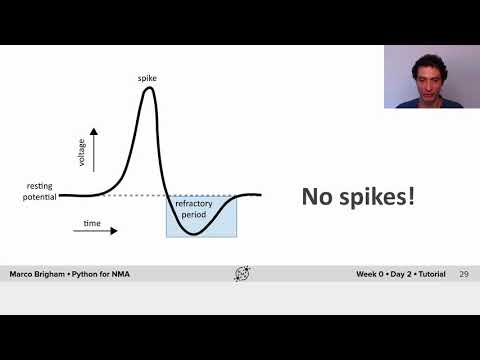

In [16]:
#@title Video: Refractory period
from IPython.display import YouTubeVideo
video = YouTubeVideo(id='DOoftC0JU2k', width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)
video

## Exercise 5
Investigate the effect of (absolute) refractory period $t_{ref}$ on the evolution of output rate $\lambda(t)$. Add refractory period $t_{ref}=10$ ms after each spike, during which $V(t)$ is clamped to $V_{reset}$.

Experiment increasingly higher values of refractory period $t_{ref}$

**Suggestions**
* At each time step:
  * Manage spike times as in the previous exercise
  * Update numpy array `last_spike` with time `t` for spiking neurons
  * Initialize boolean numpy array `clamped` using `last_spike`, `t` and `t_ref`
  * Reset to `vr` clamped neurons using `clamped`

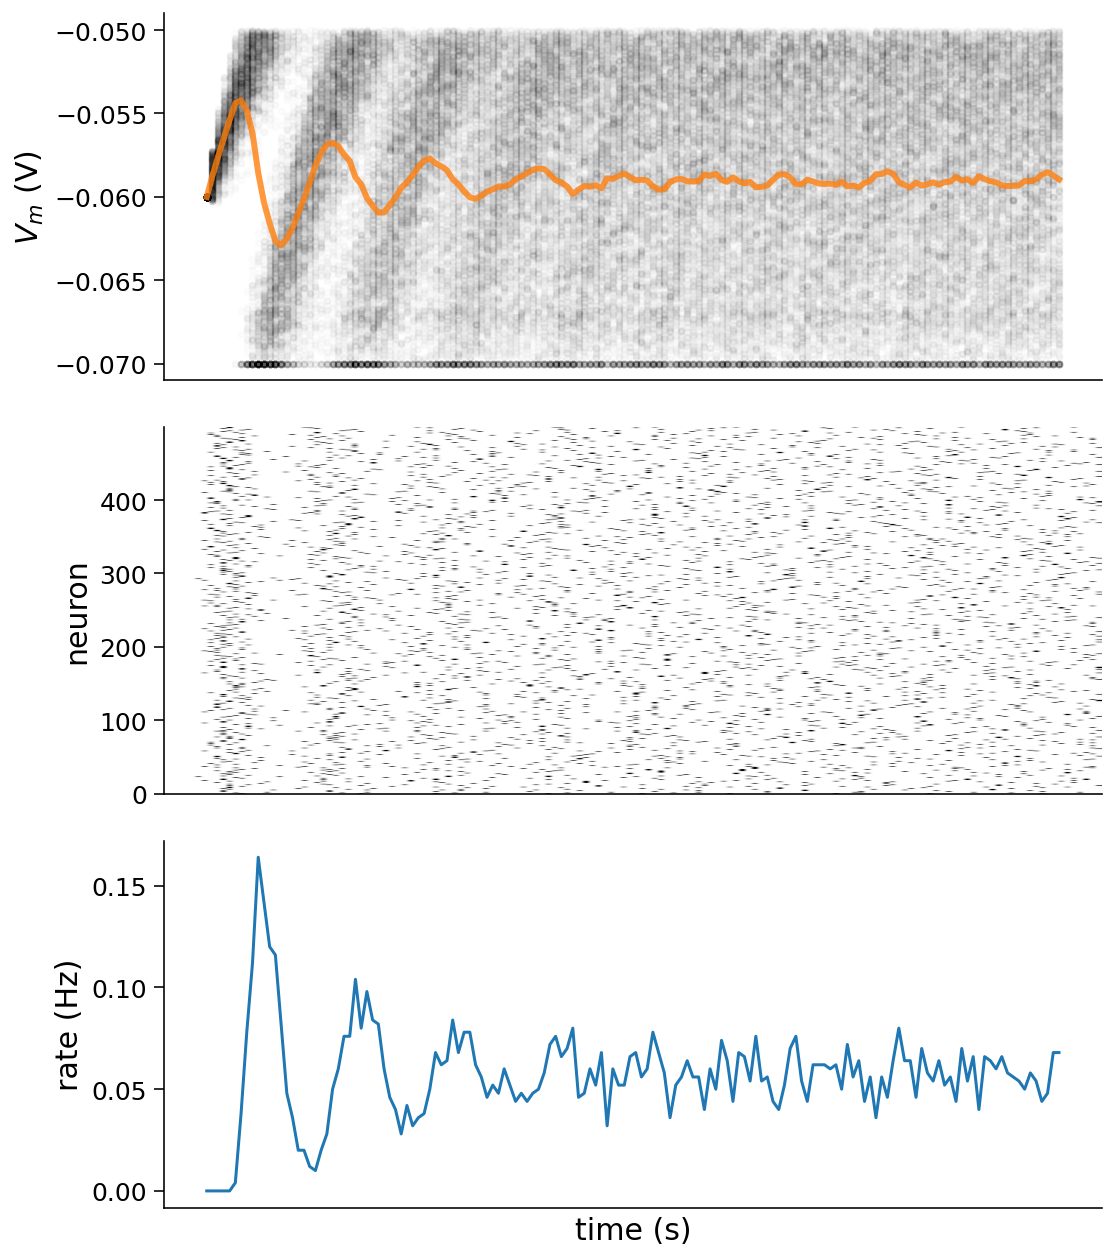

In [17]:
# set random number generator
np.random.seed(2020)

# initialize step_end, t_range, n, v_n, syn and raster
t_range = np.arange(0, t_max, dt)
step_end = len(t_range)
n = 500
v_n = el * np.ones([n,step_end])
syn = i_mean * (1 + 0.1*(t_max/dt)**(0.5)*(2*np.random.random([n,step_end])-1))
raster = np.zeros([n,step_end])

# initialize t_ref and last_spike
t_ref = 0.01
last_spike = -t_ref * np.ones([n])

# loop time steps
for step, t in enumerate(t_range):
  if step==0:
    continue

  v_n[:,step] = v_n[:,step-1] + dt/tau * (el - v_n[:,step-1] + r*syn[:,step])

  # boolean array spiked indexes neurons with v>=vth
  spiked = (v_n[:,step] >= vth)
  v_n[spiked,step] = vr
  raster[spiked,step] = 1.

  # boolean array clamped indexes refractory neurons  
  clamped = ...
  # Complete these lines and uncomment
  # v_n[clamped,step] = ...
  # last_spike[spiked] = ...

# plot multiple realizations of Vm, spikes and mean spike rate
plot_all(t_range, v_n, raster)

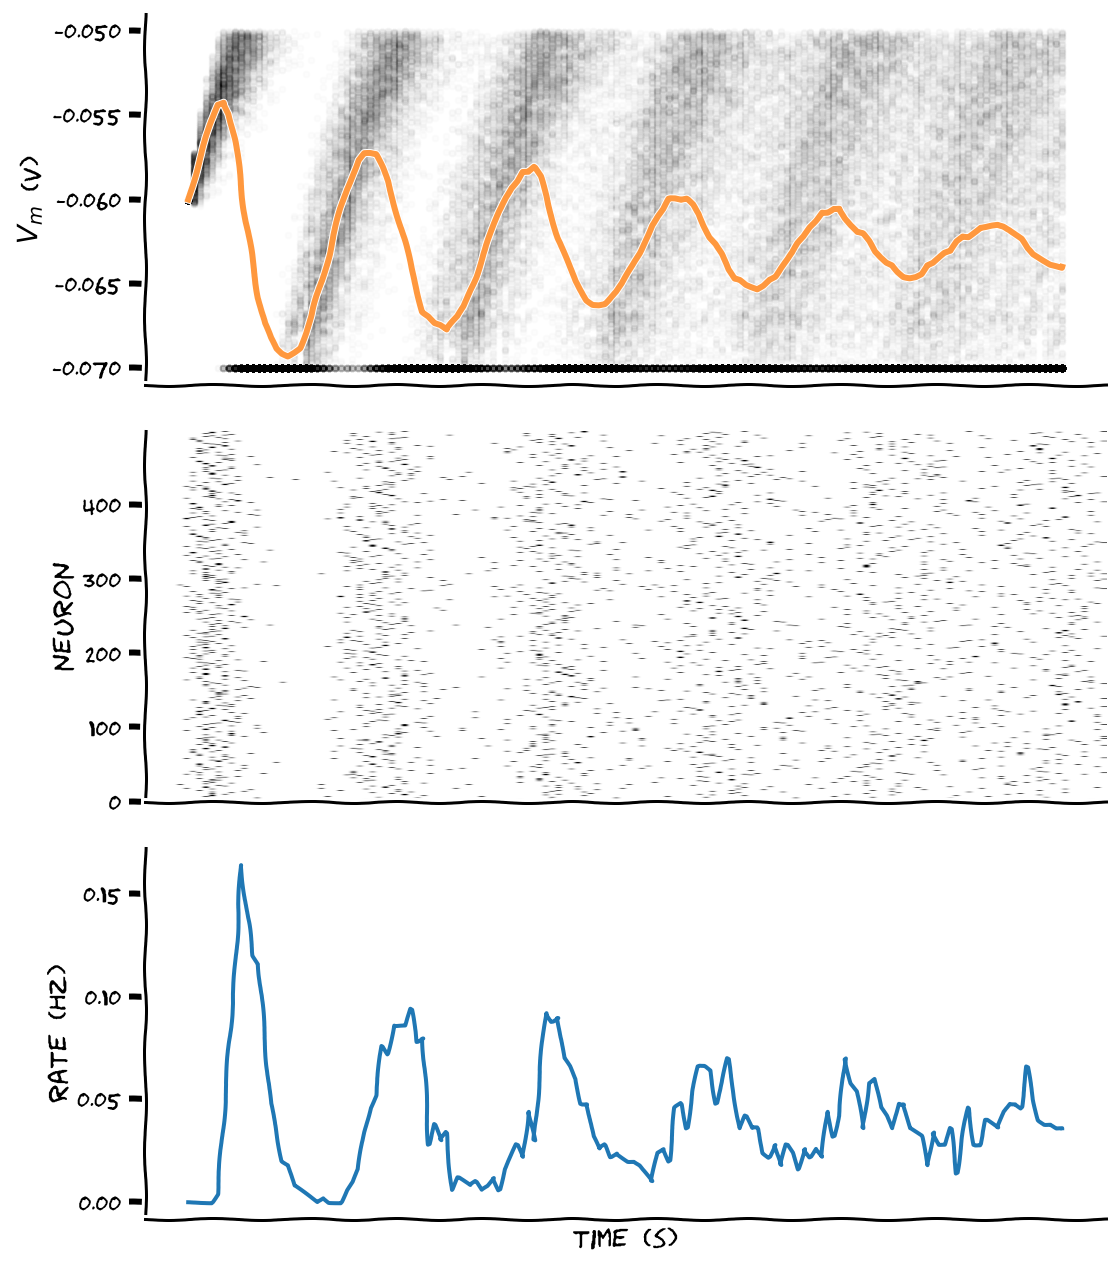

In [18]:
# to_remove solution
# set random number generator
np.random.seed(2020)

# initialize step_end, t_range, n, v_n, syn and raster
t_range = np.arange(0, t_max, dt)
step_end = len(t_range)
n = 500
v_n = el * np.ones([n,step_end])
syn = i_mean * (1 + 0.1*(t_max/dt)**(0.5)*(2*np.random.random([n,step_end])-1))
raster = np.zeros([n,step_end])

# initialize t_ref and last_spike
t_ref = 0.01
last_spike = -t_ref * np.ones([n])

# loop time steps
for step, t in enumerate(t_range):
  if step==0:
    continue

  v_n[:,step] = v_n[:,step-1] + dt/tau * (el - v_n[:,step-1] + r*syn[:,step])

  # boolean array spiked indexes neurons with v>=vth
  spiked = (v_n[:,step] >= vth)
  v_n[spiked,step] = vr
  raster[spiked,step] = 1.

  # boolean array clamped indexes refractory neurons  
  clamped = (last_spike + t_ref > t)
  v_n[clamped,step] = vr
  last_spike[spiked] = t

# plot multiple realizations of Vm, spikes and mean spike rate
with plt.xkcd():
  plot_all(t_range, v_n, raster)

## Random refractory period
Investigate the effect of random refractory period $t_{ref}$ with 
$t_{ref} = \mu + \sigma\,\mathcal{N}$, where $\mathcal{N}$ is the [normal distribution](https://en.wikipedia.org/wiki/Normal_distribution), $\mu=0.01$ and $\sigma=0.007$.

Refractory period samples `t_ref` of size `n` is initialized with `np.random.normal`. Remember to clip negative values to `0` with boolean indexes. (Why?)

What is the effect of different $\sigma$ values?

**Instructions**
* Please execute the cell below
* Vary values of $\sigma$ and observe changes

In [19]:
# @title Interactive demo: Parameter exploration

def random_ref_period(mu, sigma):
  # set random number generator
  np.random.seed(2020)

  # initialize step_end, t_range, n, v_n, syn and raster
  t_range = np.arange(0, t_max, dt)
  step_end = len(t_range)
  n = 500
  v_n = el * np.ones([n,step_end])
  syn = i_mean * (1 + 0.1*(t_max/dt)**(0.5)*(2*np.random.random([n,step_end])-1))
  raster = np.zeros([n,step_end])

  # initialize t_ref and last_spike
  t_ref = mu + sigma*np.random.normal(size=n)
  t_ref[t_ref<0] = 0
  last_spike = -t_ref * np.ones([n])

  # loop time steps
  for step, t in enumerate(t_range):
    if step==0:
      continue

    v_n[:,step] = v_n[:,step-1] + dt/tau * (el - v_n[:,step-1] + r*syn[:,step])

    # boolean array spiked indexes neurons with v>=vth
    spiked = (v_n[:,step] >= vth)
    v_n[spiked,step] = vr
    raster[spiked,step] = 1.

    # boolean array clamped indexes refractory neurons  
    clamped = (last_spike + t_ref > t)
    v_n[clamped,step] = vr
    last_spike[spiked] = t

  # plot multiple realizations of Vm, spikes and mean spike rate
  plot_all(t_range, v_n, raster)

  # plot histogram of t_ref
  plt.figure(figsize=(8,4))
  plt.hist(t_ref, bins=32, histtype='stepfilled', linewidth=0, color='C1')
  plt.xlabel(r'$t_{ref}$ (s)')
  plt.ylabel('count')
  plt.tight_layout()

_ = widgets.interact(random_ref_period, mu = (0.01, 0.05, 0.01), \
                              sigma = (0.001, 0.02, 0.001)) 

interactive(children=(FloatSlider(value=0.02, description='mu', max=0.05, min=0.01, step=0.01), FloatSlider(va…

---
# Using functions
Running key parts of your code inside functions improves your coding narrative by making it clearer and more flexible to future changes.

Video available at https://youtube.com/watch?v=0An_NnVWY_Q


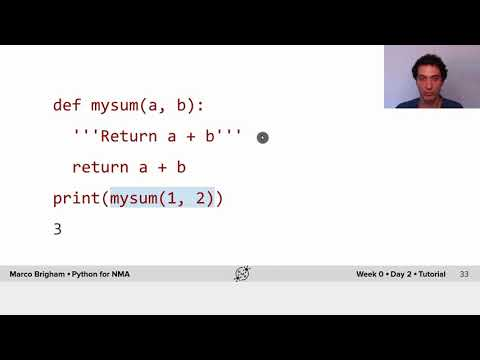

In [20]:
# @title Video: Functions
video = YouTubeVideo(id='0An_NnVWY_Q', width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)
video

## Exercise 6
Re-organize part of the code from the previous exercise with functions.

**Suggestions**
* Complete the function `spike_clamp()` to update $V(t)$ and deal with spiking and refractoriness

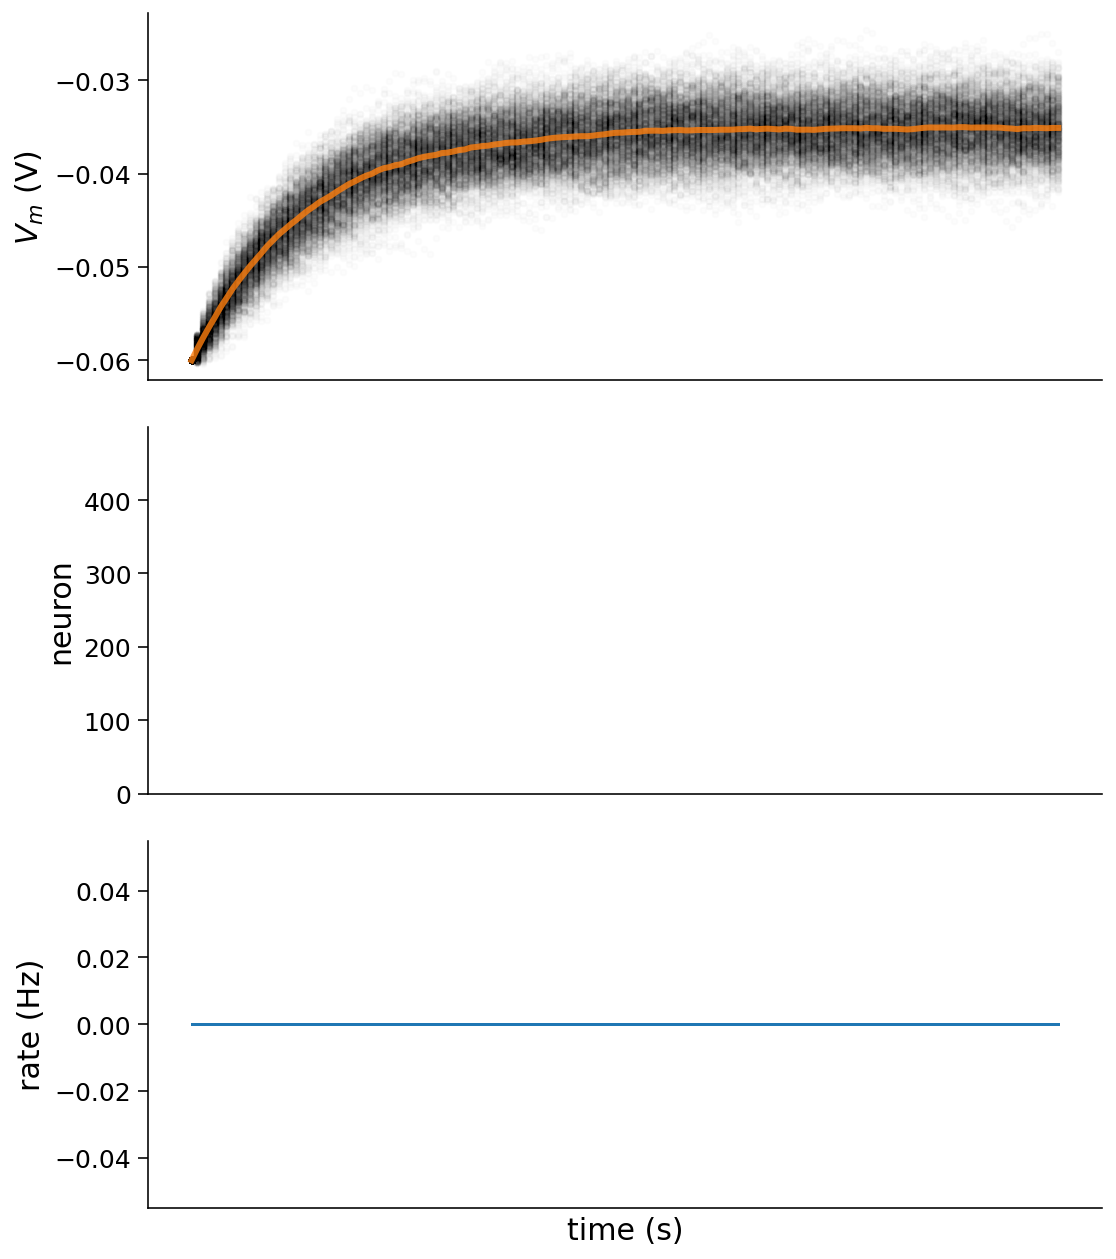

In [21]:
def ode_step(v, i, dt):
  """
  Evolves membrane potential by one step of discrete time integration
  
  Args:
    v (numpy array of floats)
      membrane potential at previous time step of shape (neurons)

    v (numpy array of floats)
      synaptic input at current time step of shape (neurons)

    dt (float)
      time step increment
            
  Returns:
    v (numpy array of floats)
      membrane potential at current time step of shape (neurons)
  """
  v = v + dt/tau * (el - v + r*i)

  return v

def spike_clamp(v, delta_spike):
  """
  Resets membrane potential of neurons if v>= vth 
  and clamps to vr if interval of time since last spike < t_ref
  
  Args:
    v (numpy array of floats)
      membrane potential of shape (neurons)

    delta_spike (numpy array of floats)
      interval of time since last spike of shape (neurons)
            
  Returns:
    v (numpy array of floats)
      membrane potential of shape (neurons)
    spiked (numpy array of floats)
      boolean array of neurons that spiked  of shape (neurons)      
  """ 

  ####################################################
  ## TODO for students: compute the mean squared error
  # Fill out function and remove
  raise NotImplementedError("Student exercise: complete the function")
  ####################################################
  # boolean array spiked indexes neurons with v>=vth
  spiked = ...
  v[spiked] = ...

  # boolean array clamped indexes refractory neurons  
  clamped = ...
  v[clamped] = ...

  return v, spiked

# set random number generator
np.random.seed(2020)

# initialize step_end, t_range, n, v_n, syn and raster
t_range = np.arange(0, t_max, dt)
step_end = len(t_range)
n = 500
v_n = el * np.ones([n,step_end])
syn = i_mean * (1 + 0.1*(t_max/dt)**(0.5)*(2*np.random.random([n,step_end])-1))
raster = np.zeros([n,step_end])

# initialize t_ref and last_spike
mu = 0.01
sigma = 0.007
t_ref = mu + sigma*np.random.normal(size=n)
t_ref[t_ref<0] = 0

# initialize t_ref and last_spike
last_spike = -t_ref * np.ones([n])

# loop time steps
for step, t in enumerate(t_range):
  if step==0:
    continue

  v_n[:,step] = ode_step(v_n[:,step-1], syn[:,step], dt)

  # Complete the`spike_clamp` function and uncomment
  # v_n[:,step], spiked = spike_clamp(v_n[:,step], t - last_spike)

  # update raster and last_spike
  # raster[spiked,step] = 1.
  # last_spike[spiked] = t

# plot multiple realizations of Vm, spikes and mean spike rate
plot_all(t_range, v_n, raster)

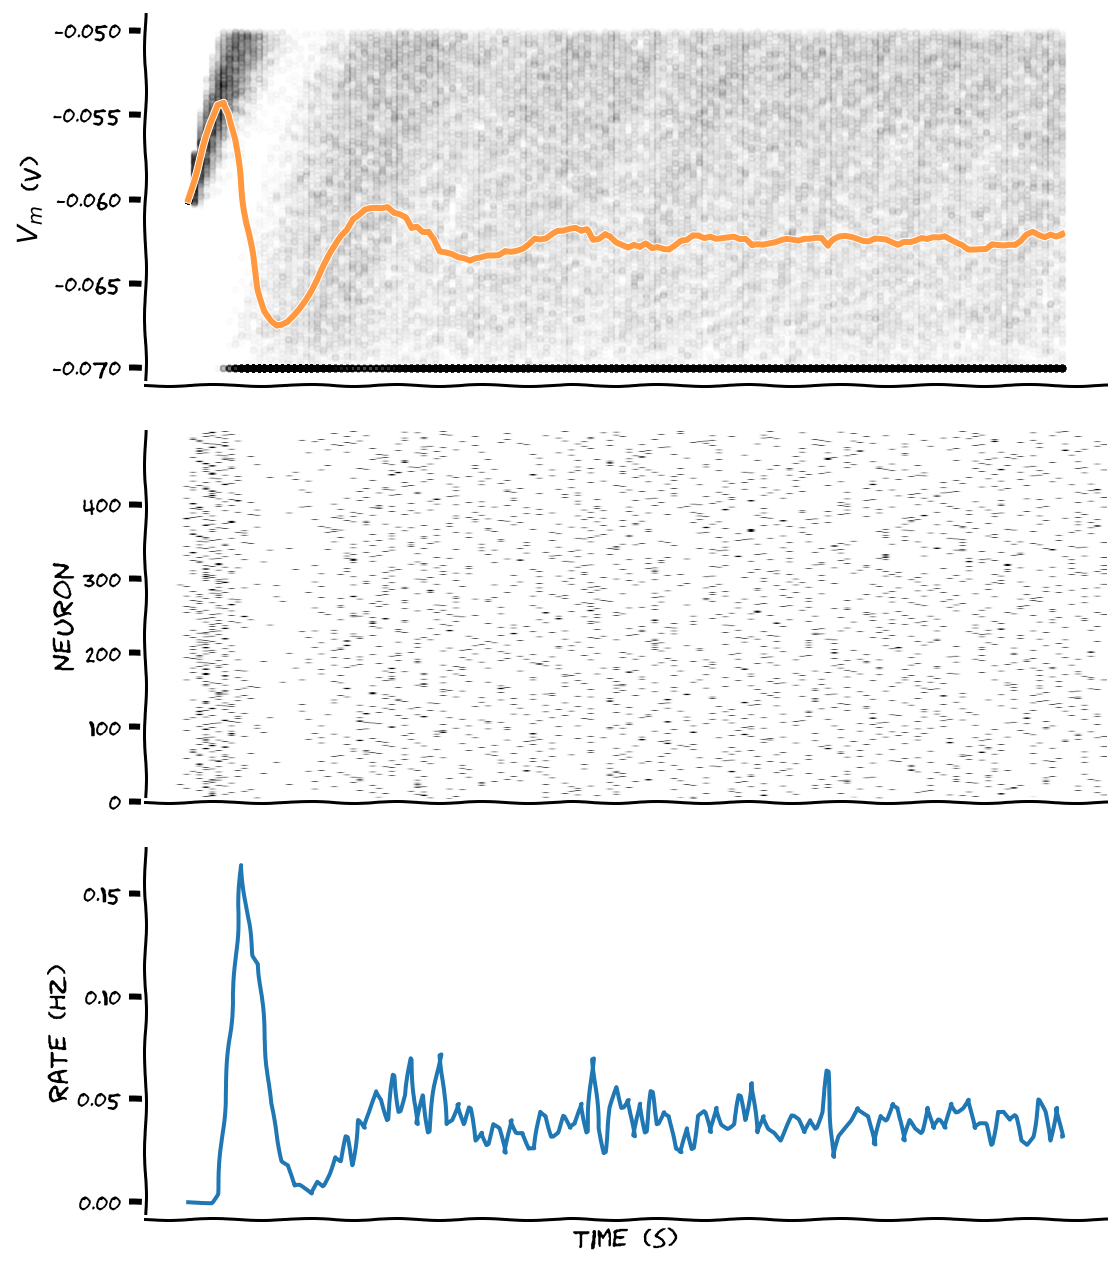

In [22]:
# to_remove solution
def ode_step(v, i, dt):
  """
  Evolves membrane potential by one step of discrete time integration
  
  Args:
    v (numpy array of floats)
      membrane potential at previous time step of shape (neurons)

    v (numpy array of floats)
      synaptic input at current time step of shape (neurons)

    dt (float)
      time step increment
            
  Returns:
    v (numpy array of floats)
      membrane potential at current time step of shape (neurons)
  """
  v = v + dt/tau * (el - v + r*i)

  return v

def spike_clamp(v, delta_spike):
  """
  Resets membrane potential of neurons if v>= vth 
  and clamps to vr if interval of time since last spike < t_ref
  
  Args:
    v (numpy array of floats)
      membrane potential of shape (neurons)

    delta_spike (numpy array of floats)
      interval of time since last spike of shape (neurons)
            
  Returns:
    v (numpy array of floats)
      membrane potential of shape (neurons)
    spiked (numpy array of floats)
      boolean array of neurons that spiked  of shape (neurons)      
  """ 
  # boolean array spiked indexes neurons with v>=vth
  spiked = (v >= vth)
  v[spiked] = vr

  # boolean array clamped indexes refractory neurons  
  clamped = (t_ref > delta_spike)
  v[clamped] = vr

  return v, spiked

# set random number generator
np.random.seed(2020)

# initialize step_end, t_range, n, v_n, syn and raster
t_range = np.arange(0, t_max, dt)
step_end = len(t_range)
n = 500
v_n = el * np.ones([n,step_end])
syn = i_mean * (1 + 0.1*(t_max/dt)**(0.5)*(2*np.random.random([n,step_end])-1))
raster = np.zeros([n,step_end])

# initialize t_ref and last_spike
mu = 0.01
sigma = 0.007
t_ref = mu + sigma*np.random.normal(size=n)
t_ref[t_ref<0] = 0

# initialize t_ref and last_spike
last_spike = -t_ref * np.ones([n])

# loop time steps
for step, t in enumerate(t_range):
  if step==0:
    continue

  v_n[:,step] = ode_step(v_n[:,step-1], syn[:,step], dt)

  v_n[:,step], spiked = spike_clamp(v_n[:,step], t - last_spike)

  # update raster and last_spike
  raster[spiked,step] = 1.
  last_spike[spiked] = t

# plot multiple realizations of Vm, spikes and mean spike rate
with plt.xkcd():
  plot_all(t_range, v_n, raster)

---
# Using classes
Using classes helps with code reuse and reliability. Well-designed classes are like black boxes in that they receive inputs and provide expected outputs. The details of how the class processes inputs and produces outputs are unimportant.

See additional details here: [A Beginner's Python Tutorial/Classes](https://en.wikibooks.org/wiki/A_Beginner%27s_Python_Tutorial/Classes)

*Attributes* are variables internal to the class, and *methods* are functions internal to the class.

Video available at https://youtube.com/watch?v=4YNpMpVW2qs


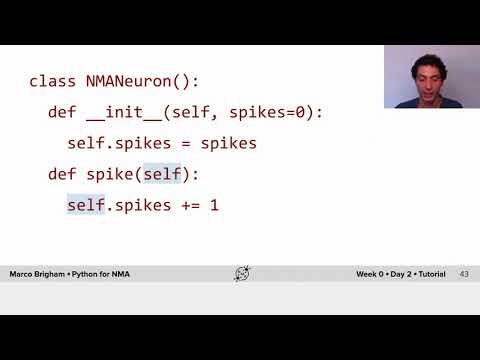

In [23]:
# @title Video: Classes
video = YouTubeVideo(id='4YNpMpVW2qs', width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)
video

## Exercise 7
In this exercise we'll practice with Python classes by implementing `LIFNeurons`, a class that evolves and keeps state of multiple realizations of LIF neurons.

Several attributes are used to keep state of our neurons:
```
self.v             current membrane potential
self.spiked        neurons that spiked
self.last_spike    last spike time of each neuron
self.t             running time of the simulation
self.steps         simulation step
```
There is a single method:
```
self.ode_step()    performs single step discrete time integration
                   for provided synaptic current and dt
```

**Suggestions**
* Complete the spike and clamp part of method `self.ode_step` (should be similar to function `spike_and_clamp` seen before)

Ran for   0s in 0 steps.


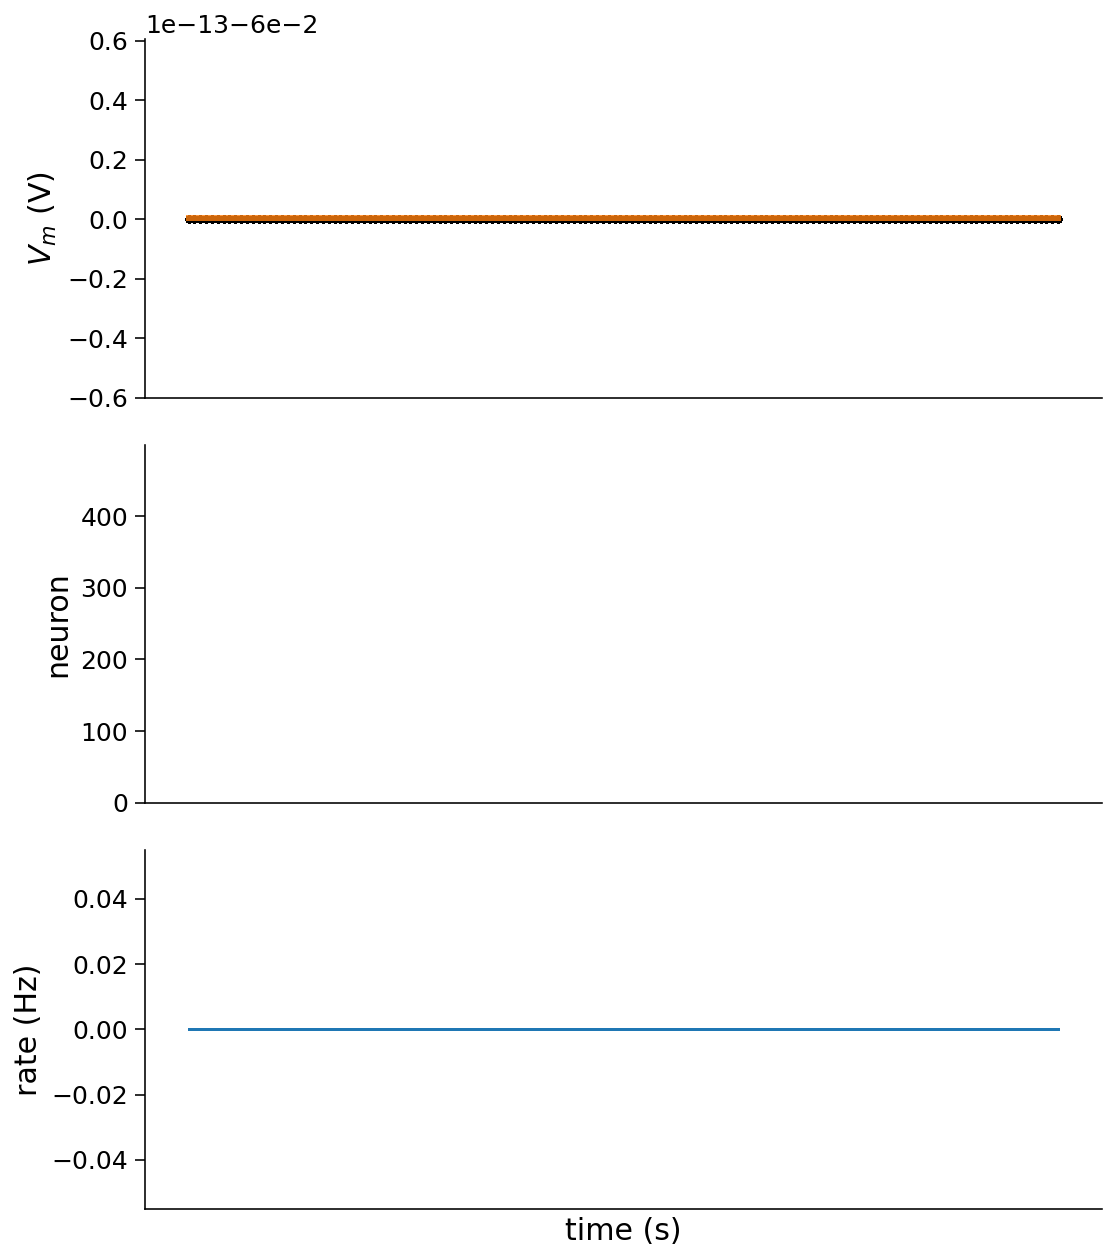

In [24]:
# simulation class
class LIFNeurons:
  """
  Keeps track of membrane potential for multiple realizations of LIF neuron, 
  and performs single step discrete time integration.
  """
  def __init__(self, n, t_ref_mu=0.01, t_ref_sigma=0.002,
               tau=20e-3, el=-60e-3, vr=-70e-3, vth=-50e-3, r=100e6
               ):
    
    # neuron count
    self.n = n

    # neuron parameters
    self.tau = tau        # second
    self.el = el          # milivolt
    self.vr = vr          # milivolt
    self.vth = vth        # milivolt
    self.r = r            # ohm

    # initializes refractory period distribution
    self.t_ref_mu = t_ref_mu
    self.t_ref_sigma = t_ref_sigma
    self.t_ref = self.t_ref_mu + self.t_ref_sigma*np.random.normal(size=self.n)
    self.t_ref[self.t_ref<0] = 0

    # state variables
    self.v = self.el * np.ones(self.n)
    self.spiked = self.v >= self.vth
    self.last_spike = -self.t_ref * np.ones([self.n])
    self.t = 0
    self.steps = 0


  def ode_step(self, dt, i):
    
    # update running time and steps
    self.t += dt
    self.steps += 1

    # one step of discrete time integration of dt
    self.v = self.v + dt/self.tau * (self.el - self.v + self.r*i)
    ####################################################
    ## TODO for students: complete the `ode_step` method
    # Fill out function and remove
    raise NotImplementedError("Student exercise: complete the method")
    ####################################################
    # spike and clamp
    self.spiked = ...
    self.v[self.spiked] = ...
    self.last_spike[self.spiked] = ...
    clamped = ...
    self.v[clamped] = ...

    self.last_spike[self.spiked] = ...


# set random number generator
np.random.seed(2020)

# initialize step_end, t_range, n, v_n, syn and raster
t_range = np.arange(0, t_max, dt)
step_end = len(t_range)
n = 500
v_n = el * np.ones([n,step_end])
syn = i_mean * (1 + 0.1*(t_max/dt)**(0.5)*(2*np.random.random([n,step_end])-1))
raster = np.zeros([n,step_end])

# initialize neurons
neurons = LIFNeurons(n)

# loop time steps
for step, t in enumerate(t_range):

  # Complete the method and uncomment
  # neurons.ode_step(dt, syn[:,step])

  # log v_n and spike history
  v_n[:,step] = neurons.v
  raster[neurons.spiked, step] = 1.

# report running time and steps
print(f'Ran for {neurons.t:3}s in {neurons.steps} steps.')

# plot multiple realizations of Vm, spikes and mean spike rate
plot_all(t_range, v_n, raster)

Ran for 0.15s in 150 steps.


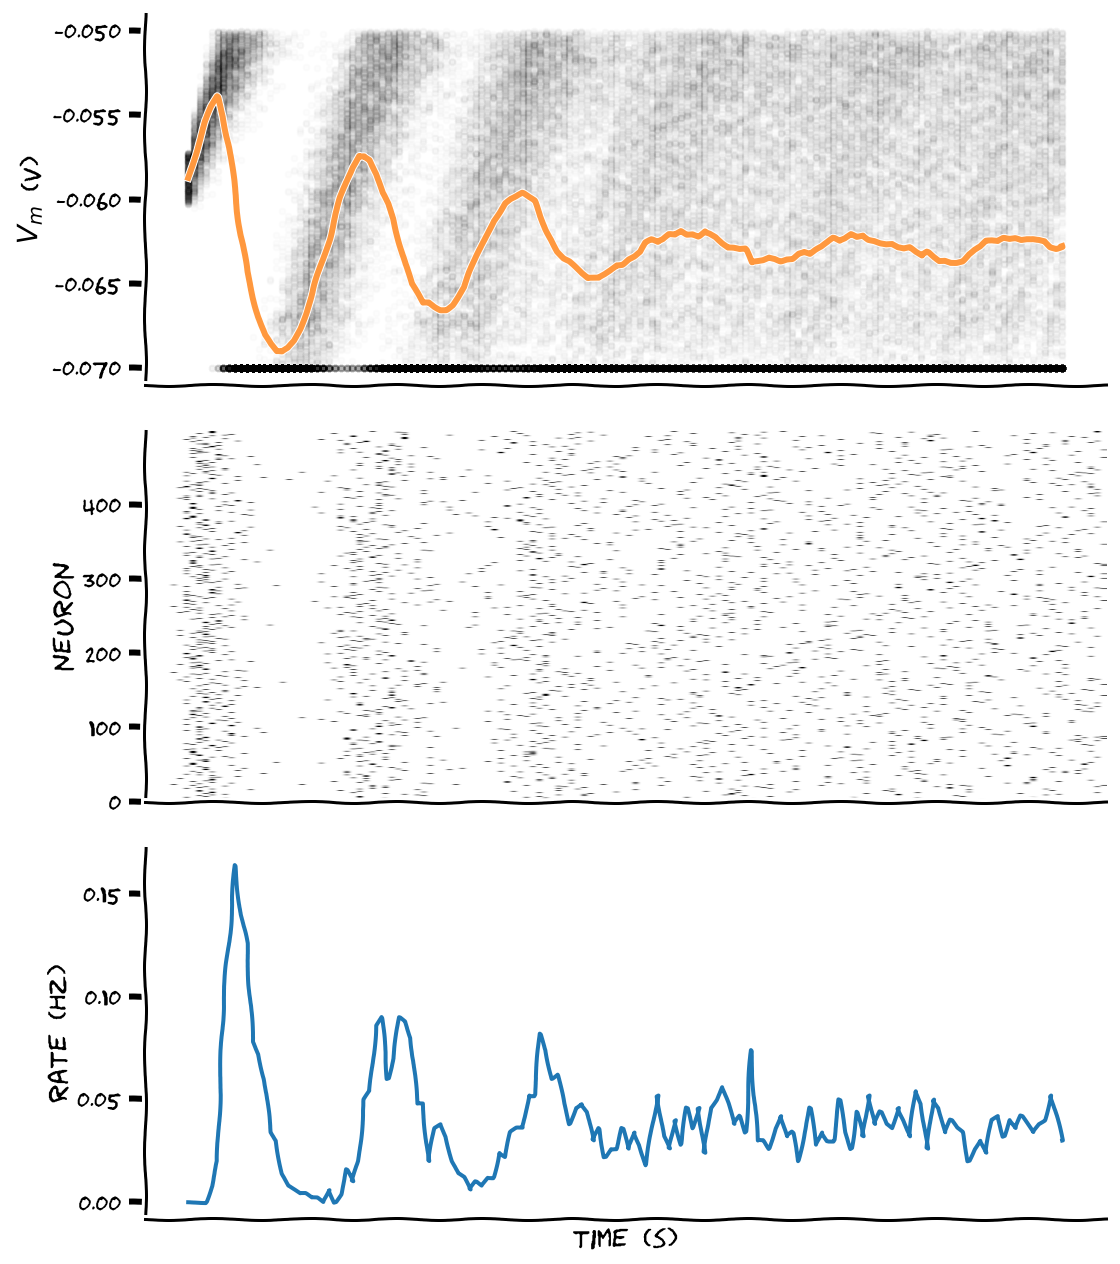

In [25]:
# to_remove solution
# simulation class
class LIFNeurons:
  """
  Keeps track of membrane potential for multiple realizations of LIF neuron, 
  and performs single step discrete time integration.
  """
  def __init__(self, n, t_ref_mu=0.01, t_ref_sigma=0.002,
               tau=20e-3, el=-60e-3, vr=-70e-3, vth=-50e-3, r=100e6
               ):
    
    # neuron count
    self.n = n

    # neuron parameters
    self.tau = tau        # second
    self.el = el          # milivolt
    self.vr = vr          # milivolt
    self.vth = vth        # milivolt
    self.r = r            # ohm

    # initializes refractory period distribution
    self.t_ref_mu = t_ref_mu
    self.t_ref_sigma = t_ref_sigma
    self.t_ref = self.t_ref_mu + self.t_ref_sigma*np.random.normal(size=self.n)
    self.t_ref[self.t_ref<0] = 0

    # state variables
    self.v = self.el * np.ones(self.n)
    self.spiked = self.v >= self.vth
    self.last_spike = -self.t_ref * np.ones([self.n])
    self.t = 0
    self.steps = 0


  def ode_step(self, dt, i):
    
    # update running time and steps
    self.t += dt
    self.steps += 1

    # one step of discrete time integration of dt
    self.v = self.v + dt/self.tau * (self.el - self.v + self.r*i)

    # spike and clamp
    self.spiked = (self.v >= self.vth)
    self.v[self.spiked] = self.vr
    self.last_spike[self.spiked] = self.t
    clamped = (self.t_ref > self.t-self.last_spike)
    self.v[clamped] = self.vr

    self.last_spike[self.spiked] = self.t
      

# set random number generator
np.random.seed(2020)

# initialize step_end, t_range, n, v_n, syn and raster
t_range = np.arange(0, t_max, dt)
step_end = len(t_range)
n = 500
v_n = el * np.ones([n,step_end])
syn = i_mean * (1 + 0.1*(t_max/dt)**(0.5)*(2*np.random.random([n,step_end])-1))
raster = np.zeros([n,step_end])

# initialize neurons
neurons = LIFNeurons(n)

# loop time steps
for step, t in enumerate(t_range):

  neurons.ode_step(dt, syn[:,step])

  # log v_n and spike history
  v_n[:,step] = neurons.v
  raster[neurons.spiked, step] = 1.

# report running time and steps
print(f'Ran for {neurons.t:.3}s in {neurons.steps} steps.')

# plot multiple realizations of Vm, spikes and mean spike rate
with plt.xkcd():
  plot_all(t_range, v_n, raster)